In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from itertools import groupby
import itertools
import re
import matplotlib.ticker as mtick

# Define the root directory
root_dir = '/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/material_lists/'


In [3]:
occupations =['Business and Financial Operations Occupations',
'Computer and Mathematical Occupations',
'Management Occupations']

occupations_file_names = [occ.lower().replace(' ', '_') for occ in occupations]


In [4]:
df_all = pd.DataFrame()
for occ in occupations_file_names:
    df = pd.read_csv(f'/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/material_lists/claude-3-7-sonnet-20250219/task_list_{occ}_CORE.csv')
    df['occupation_group'] = occ
    print(len(df['occupation'].unique()))
    df_all = pd.concat([df_all, df], ignore_index=True)

43
30
50


In [84]:
df.columns

Index(['Unnamed: 0', 'row', 'prompt', 'task_id', 'occupation',
       'task_description', 'can_be_performed_remotely', 'feasiblity_practical',
       'chain_of_thought', 'tools.Coding', 'tools.Spreadsheets',
       'tools.Text editor', 'tools.PDF viewer', 'tools.Presentation software',
       'tools.Online search engine', 'tools.Image Generator',
       'tools.Other.name', 'tools.Other.classification', 'materials.Text',
       'materials.Data', 'materials.Images', 'materials.Audio files',
       'materials.Video files',
       'materials.Virtual labs or sandbox environments',
       'materials.Other.name', 'materials.Other.classification',
       'required_tools', 'required_tools_standard', 'required_materials',
       'required_materials_standard', 'occupation_group'],
      dtype='object')

# Individual barplots per occupation group of shares of tasks requiring materials/ tools

In [85]:
def get_shares(df):

    material_columns = ['materials.Text', 'materials.Data',
    'materials.Images', 'materials.Audio files', 'materials.Video files',
    'materials.Virtual labs or sandbox environments']
    tool_columns =  ['tools.Coding', 'tools.Spreadsheets',\
    'tools.Text editor', 'tools.PDF viewer', 'tools.Presentation software',\
    'tools.Online search engine', 'tools.Image Generator']
    relevant_columns = material_columns + tool_columns
    df_binary = (df[relevant_columns] =='Required').astype(int)


    df_shares = df_binary.sum()/df.shape[0]
    df_shares = pd.DataFrame(df_shares).reset_index().rename(columns={0:'Value', 'index':'Category'})
    df_shares.loc[df_shares['Category']  == 'materials.Virtual labs or sandbox environments', 'Category'] ='materials.Virtual labs'
    # Separate materials and tools
    materials = df_shares[df_shares['Category'].str.startswith('materials')]
    tools = df_shares[df_shares['Category'].str.startswith('tools')]

    return [materials, tools]

In [86]:
def plot_horizontal_bars(ax, data, title, color, bar_height):
    bars = ax.barh(
        data['Category'].str.replace('materials.|tools.', '', regex=True),
        data['Value'],
        color=color,
        height=bar_height  # <-- Uniform bar thickness
    )
    ax.set_title(title, fontsize=title_fontsize)
    ax.invert_yaxis()
    ax.set_xlim(0, 1)
    ax.set_xlabel('Percentage', fontsize=label_fontsize)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # Remove plot borders
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Add percentage labels to bars
    for bar in bars:
        width = bar.get_width()
        label = f"{width*100:.0f}%"
        if width > 0.2:
            ax.text(width - 0.02, bar.get_y() + bar.get_height()/2,
                    label, ha='right', va='center', color='white', fontsize=annot_fontsize, fontweight='bold')
        else:
            ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                    label, ha='left', va='center', fontsize=annot_fontsize)



In [87]:
def create_dual_bar_plot(df, occ_group):
    df = df[df['occupation_group'] == occ_group]
    materials, tools = get_shares(df)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(13, 7))  # Adjust to fit nicely

    # Define manual colors
    material_color = '#8E3B46'  
    tool_color ='#739E82'     

    bar_height = 0.6

    # Common font sizes
    title_fontsize = 16
    label_fontsize = 13
    tick_fontsize = 11
    annot_fontsize = 11

    # Plot for materials and tools
    plot_horizontal_bars(axes[0], materials, 'Materials', material_color, bar_height)
    plot_horizontal_bars(axes[1], tools, 'Tools', tool_color, bar_height)

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'../../results/figures/{occ}_materials_tools.png', dpi=300, bbox_inches='tight')
    plt.show()



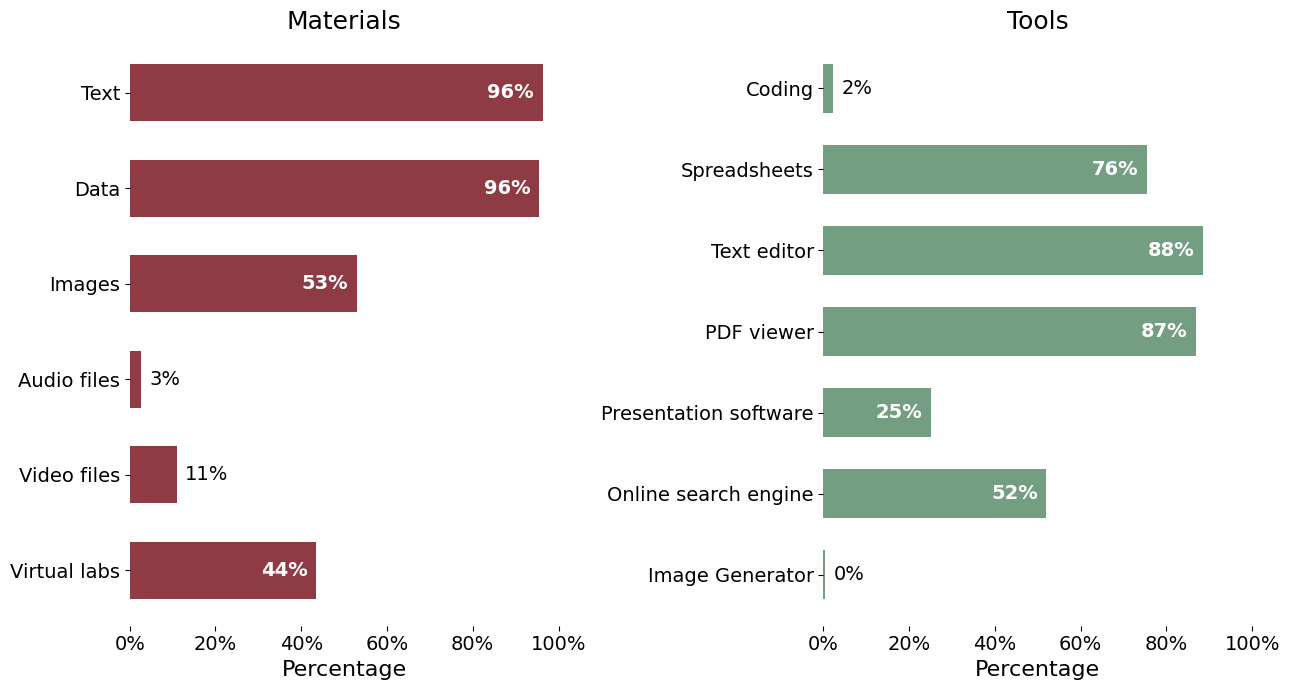

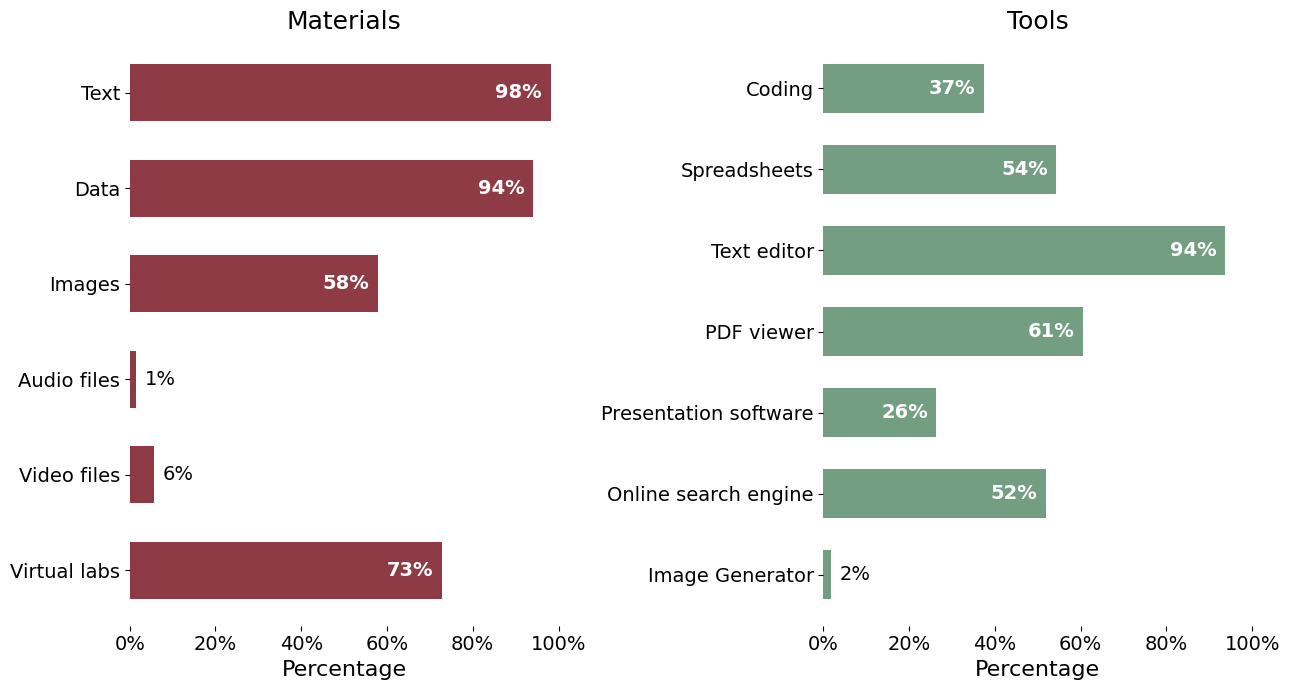

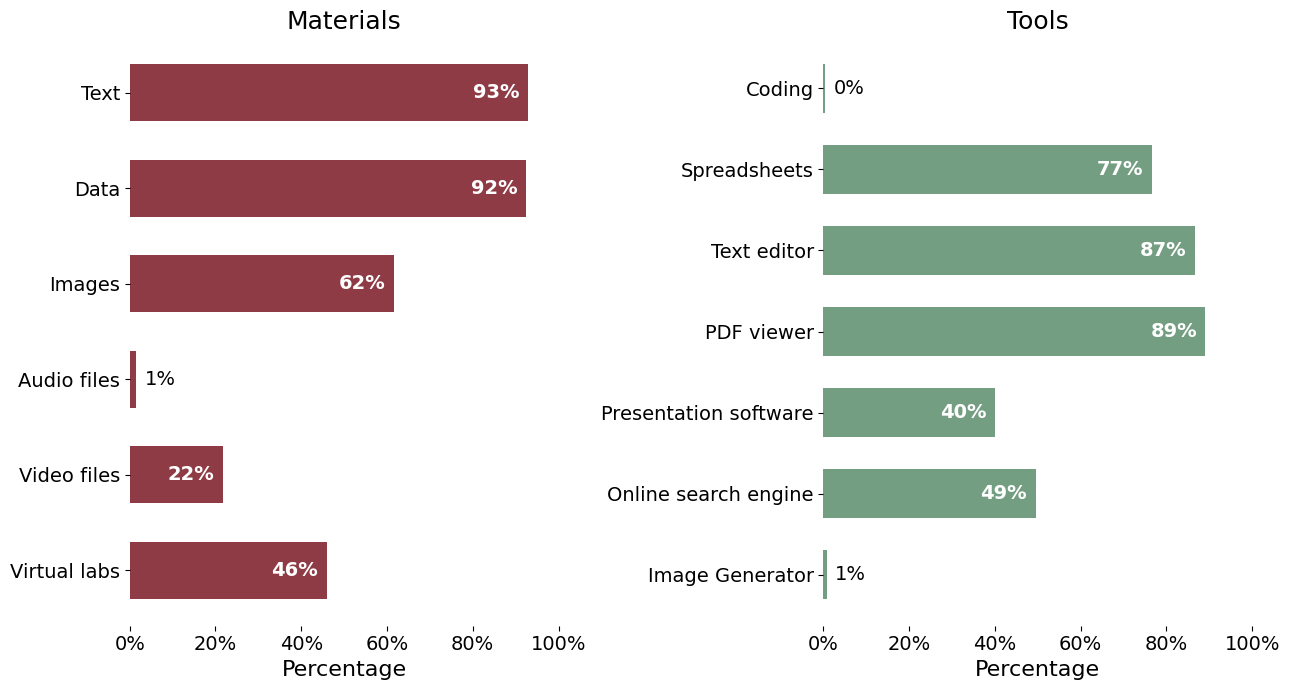

In [88]:
for occ_group in occupations_file_names:
    create_dual_bar_plot(df_all, occ_group)

# Grouped version of plot

In [89]:
tools_data = pd.DataFrame()
materials_data = pd.DataFrame()
for occ_group in occupations_file_names:
    materials, tools = get_shares(df_all[df_all['occupation_group'] == occ_group])
    materials.index = materials['Category'].str.replace('materials.', '', regex=True)
    materials.drop('Category', axis=1, inplace=True)

    tools.index = tools['Category'].str.replace('tools.', '', regex=True)
    tools.drop('Category', axis=1, inplace=True)
    materials_data = pd.concat([materials_data, materials.rename(columns={'Value':occ_group})],axis=1)
    tools_data = pd.concat([tools_data, tools.rename(columns={'Value':occ_group})], axis=1)


In [90]:
tools_data

,business_and_financial_operations_occupations,computer_and_mathematical_occupations,management_occupations
Category,,,
Coding,0.022222,0.374771,0.003559
Spreadsheets,0.755556,0.542962,0.766311
Text editor,0.884444,0.936015,0.867141
PDF viewer,0.869630,0.605119,0.890866
Presentation software,0.250370,0.263254,0.400949
Online search engine,0.520000,0.519196,0.494662
Image Generator,0.002963,0.018282,0.007117


In [91]:

def plot_grouped_horizontal_bars(ax, data, title, colors, bar_height, occupations_file_names):
    categories = data['Category'].str.replace('materials.|tools.', '', regex=True).unique()
    groups = occupations_file_names

    y = np.arange(len(categories))
    group_width = bar_height * len(groups)
    offsets = np.linspace(-group_width/2 + bar_height/2, group_width/2 - bar_height/2, len(groups))

    ax.set_title(title, fontsize=title_fontsize)
    ax.invert_yaxis()
    ax.set_xlim(0, 1)
    ax.set_xlabel('Percentage', fontsize=label_fontsize)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_yticks(y)
    ax.set_yticklabels(categories, fontsize=tick_fontsize)
    ax.tick_params(axis='x', which='major', labelsize=tick_fontsize)

    for spine in ax.spines.values():
        spine.set_visible(False)

    bars_list = []  # for legend handles

    for i, group in enumerate(groups):
        values = data[group].values

        bars = ax.barh(
            y + offsets[i],
            values,
            height=bar_height,
            color=colors[i],
            label=group.title().replace('_', ' '),
            alpha=0.7,
            edgecolor=colors[i],
        )

        bars_list.append(bars[0])  # Save one bar per group for the legend

        for bar in bars:
            width = bar.get_width()
            label = f"{width*100:.0f}%"
            if width > 0.2:
                ax.text(width - 0.02, bar.get_y() + bar.get_height()/2,
                        label, ha='right', va='center', color='black', fontsize=annot_fontsize)
            else:
                ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                        label, ha='left', va='center', fontsize=annot_fontsize)

    return bars_list  # Return bar objects for legend

# ---- Now, when plotting ----

/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_99058/2264058017.py:40: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(


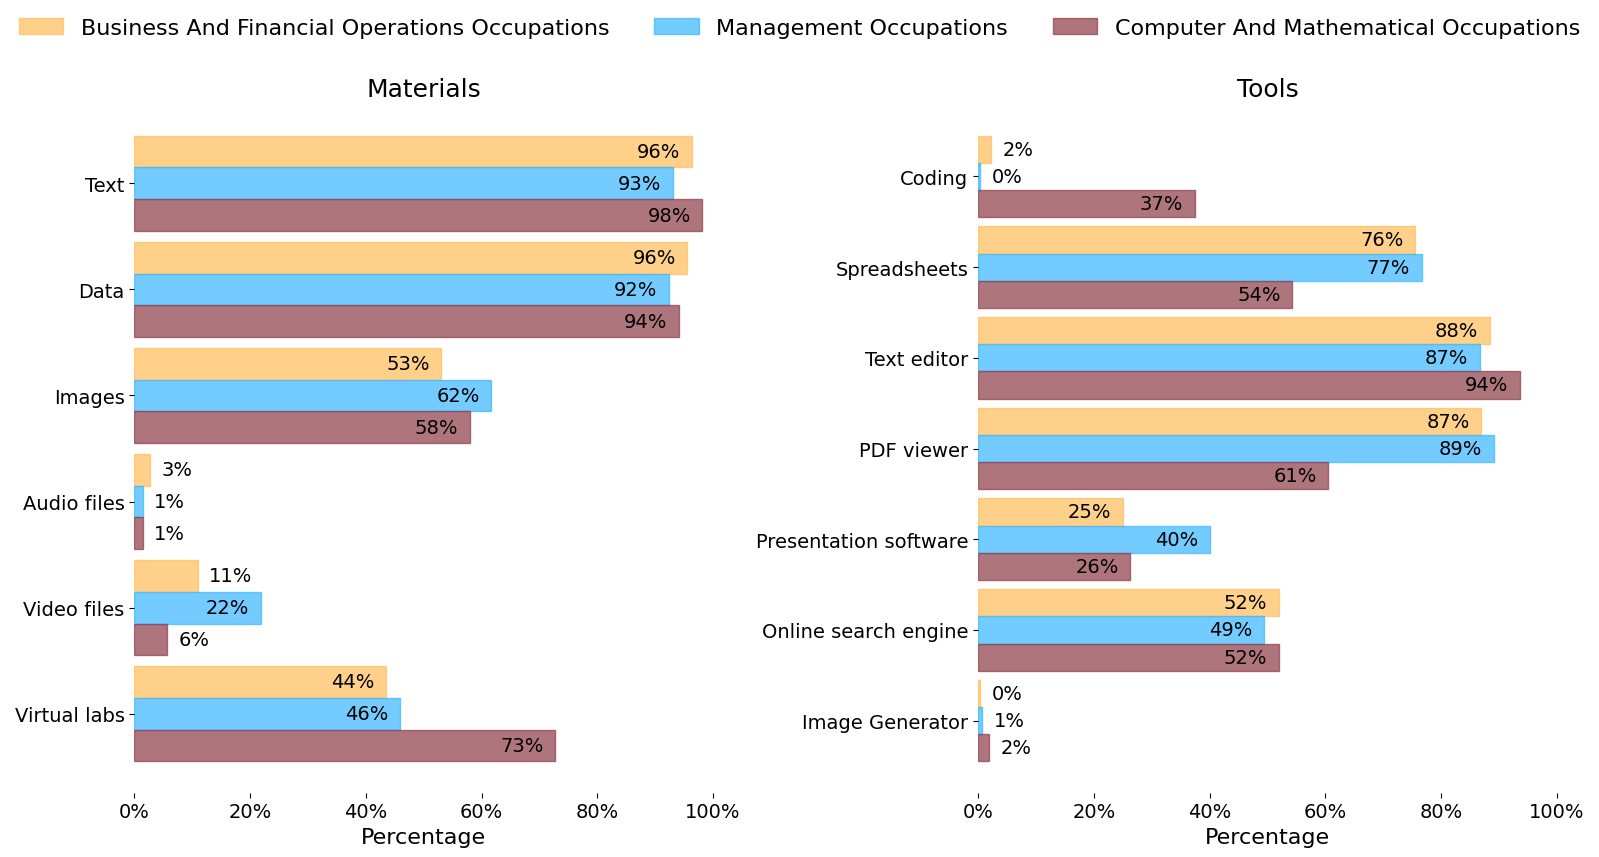

In [220]:
#FFBD59
#38B6FF
#8E3B46
#E0777D
#739E82

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(wspace=0.4)  # Increase space between the two plots



# Adjust font sizes
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 14
annot_fontsize = 14

# Plot materials
bars_materials = plot_grouped_horizontal_bars(
    axes[0],
    materials_data.reset_index(),
    'Materials',
    ['#FFBD59','#38B6FF','#8E3B46'],
    0.3,
    occupations_file_names
)

# Plot tools
bars_tools = plot_grouped_horizontal_bars(
    axes[1],
    tools_data.reset_index(),
    'Tools',
    ['#FFBD59','#38B6FF','#8E3B46'],
    0.3,
    occupations_file_names
)

# Joint legend at top center
fig.legend(
    bars_materials,  # or bars_tools (they're the same bar styles)
    labels=[group.title().replace('_', ' ') for group in occupations_file_names],
    loc='upper center',
    ncol=len(occupations_file_names),
    fontsize=label_fontsize,
    frameon=False,
    bbox_to_anchor=(0.5, 1.08)  # Center it above the plots
)

plt.tight_layout()
plt.savefig('../../results/figures/grouped_materials_tools.pdf', dpi=300, bbox_inches='tight')
plt.show()


# Shares of tasks included per occupation group 

In [93]:
# # get exclusions lists
# excl_lists = pd.DataFrame()
# for occ in occupations_file_names:
#     exclusion = pd.read_csv(f'../../data/exam_approach/exclusion_lists/{occ}_only_data_text_CORE.csv',index_col=0).rename(columns={'0':'task_id'})
#     exclusion['occupation_group'] = occ
#     excl_lists = pd.concat([excl_lists, exclusion], axis=0, ignore_index=True)

In [5]:
# get exams
exam_list = pd.DataFrame()
for occ in occupations_file_names:
    results = pd.read_csv(f'../../data/exam_approach/test_results/claude-3-7-sonnet-20250219/test_results_{occ}.csv',index_col=0)
    results = results.loc[:, ~results.columns.str.startswith('Unnamed')]
    results['occupation_group'] = occ
    exam_list = pd.concat([exam_list, results], axis=0, ignore_index=True)

In [6]:
# mark exams with empty entry, nan entry or key grade scores over 100 as invalid
exam_list.loc[exam_list['exam']=='','exam'] = 'Exam not valid'
exam_list['exam'] = exam_list['exam'].fillna('Exam not valid')
exam_list.loc[exam_list['key_grade']>100,'exam'] = 'Exam not valid'
exam_list.loc[exam_list['score_empty_submission']>0, 'exam'] = 'Exam not valid'


exam_list.loc[np.any(exam_list[['score_gemini_25',
    'score_claude_sonnet',
    'score_claude_haiku',
    'score_chatgpt_o3',
    'score_deepseek',
    'score_gemini_flash_15',
    'score_gemini_flash',
    'score_claude_sonnet_35',
    'score_chatgpt4o']]>100,axis=1), 'exam'] = 'Exam not valid'

In [7]:
# count number of tasks per occupation group
overall_count = df_all.groupby('occupation_group')['task_id'].nunique().rename('\# of tasks')
# count number of examined tasks per occupation group
examined_tasks_count = exam_list.groupby('occupation_group')['task_id'].nunique().rename('\# of examined tasks')

# create table with overview statistics
stats_table= pd.concat([overall_count, examined_tasks_count], axis=1)
stats_table['\% of examined tasks'] = np.round(stats_table['\# of examined tasks'] / stats_table['\# of tasks']*100,2)

In [8]:
# count valid exams per occupation group
valid_exams = exam_list[exam_list['exam']!='Exam not valid'].groupby('occupation_group')['task_id'].nunique().rename('\# of valid exams')

In [9]:
stats_table = pd.concat([stats_table, valid_exams], axis=1)
stats_table['\% of valid exams'] = np.round(stats_table['\# of valid exams'] / stats_table['\# of examined tasks']*100,2)
stats_table.index = [group.title().replace('_',' ') for group in occupations_file_names]

In [10]:
stats_table = stats_table.round(2)
stats_table

,\# of tasks,\# of examined tasks,\% of examined tasks,\# of valid exams,\% of valid exams
Business And Financial Operations Occupations,675,67,9.93,48,71.64
Computer And Mathematical Occupations,546,32,5.86,20,62.50
Management Occupations,843,43,5.10,32,74.42


In [11]:
latex_code = stats_table.to_latex(
    escape=False,   # Allows LaTeX special characters like '&' to appear correctly
    multicolumn=True,  # Adds multi-column support in the output for the column names
    header=True,    # Include the header row (column labels)
    index=True,
    float_format="%.2f"      # Include the index (row labels)
)
with open("../../results/tables/exam_stats.tex", "w") as f:
    f.write(latex_code)

In [101]:
task_count = df_all.groupby('occupation').size()
attempt_count = exam_list.groupby('occupation').size()
success_count = exam_list[exam_list['exam'] != 'Exam not valid'].groupby('occupation').size()

counts = pd.concat([task_count, attempt_count, success_count], axis=1).rename(columns={0:'\# of tasks', 1:'\# of attempts', 2:'\# of successes'})
counts = counts.merge(df_all[['occupation', 'occupation_group']].drop_duplicates(), on='occupation', how='left')
counts

,occupation,\# of tasks,\# of attempts,\# of successes,occupation_group
0,Accountants and Auditors,20,2.0,2.0,business_and_financial_operations_occupations
1,Actuaries,12,5.0,4.0,computer_and_mathematical_occupations
2,Administrative Services Managers,5,2.0,1.0,management_occupations
3,Advertising and Promotions Managers,13,1.0,1.0,management_occupations
4,"Agents and Business Managers of Artists, Perfo...",9,NaN,NaN,business_and_financial_operations_occupations
...,...,...,...,...,...
117,Web Administrators,34,NaN,NaN,computer_and_mathematical_occupations
118,Web Developers,23,NaN,NaN,computer_and_mathematical_occupations
119,"Wholesale and Retail Buyers, Except Farm Products",10,NaN,NaN,business_and_financial_operations_occupations
120,Wind Energy Development Managers,15,NaN,NaN,management_occupations


In [102]:
counts = counts.sort_values(['occupation_group', 'occupation']).reset_index(drop=True)

# Create a new DataFrame to store the final result
new_rows = []
i=0
blank_row_names =[' ','  ','   ','    ','     ','      ']
# Iterate over each group
for group_name, group_df in counts.groupby('occupation_group'):
    # Create the label row
    label_row = {
        'occupation': group_name.replace('_', ' ').title(),  # optional: prettify
        '\# of tasks': np.nan,
        '\# of attempts': np.nan,
        '\# of successes': np.nan,
        'occupation_group': group_name
    }
    blank_row = {
        'occupation': blank_row_names[i],  # optional: prettify
        '\# of tasks': np.nan,
        '\# of attempts': np.nan,
        '\# of successes': np.nan,
        'occupation_group': np.nan
    }
    new_rows.append(pd.DataFrame([blank_row]))
    i+=1
    # Append the label row and the group rows
    new_rows.append(pd.DataFrame([label_row]))
    blank_row = {
    'occupation': blank_row_names[i],  # optional: prettify
    '\# of tasks': np.nan,
    '\# of attempts': np.nan,
    '\# of successes': np.nan,
    'occupation_group': np.nan
    }
    new_rows.append(pd.DataFrame([blank_row]))
    new_rows.append(group_df)
    i+=1

# Concatenate all parts into one final DataFrame
df_with_labels = pd.concat(new_rows, ignore_index=True)

/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_99058/1188128420.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])


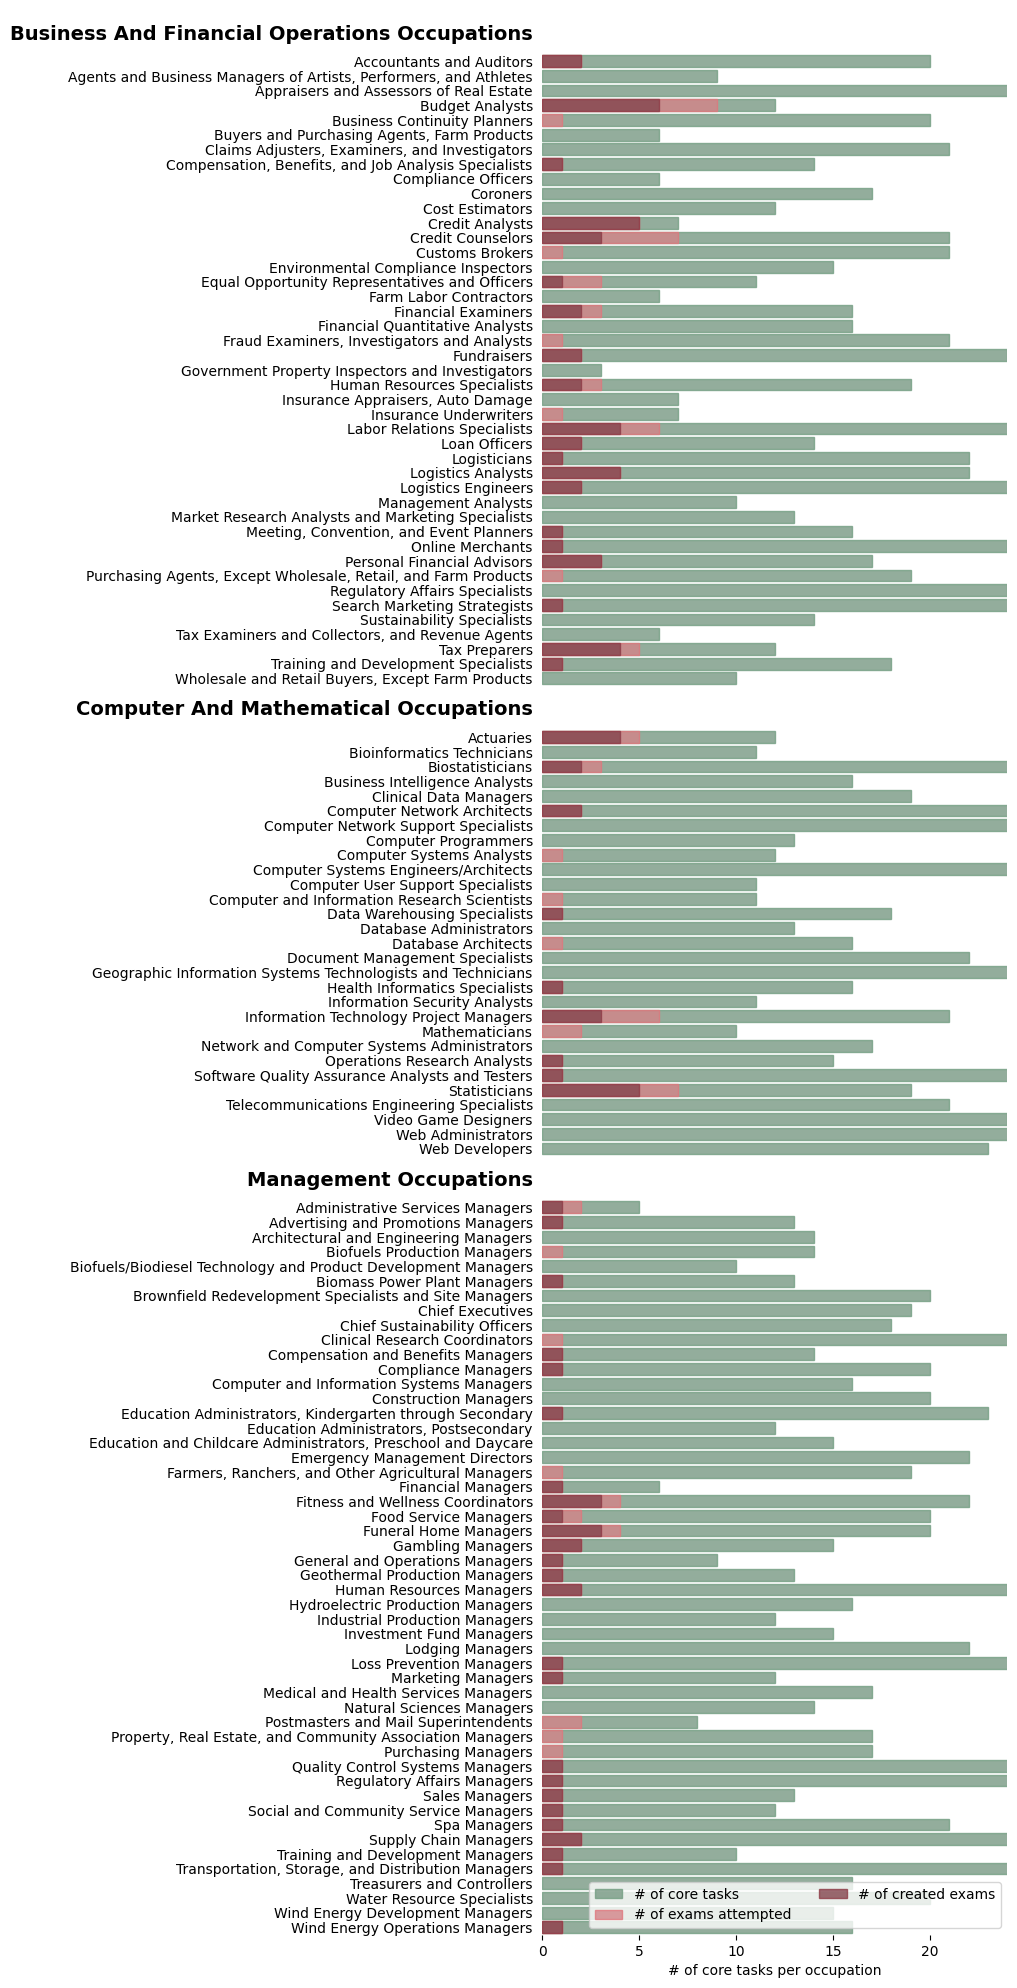

In [133]:
#FFBD59
#38B6FF
#8E3B46
#E0777D
#739E82


# # Insert blank rows between groups to add spacing
# spaced_counts = pd.DataFrame()
# for i, (group_name, group_df) in enumerate(counts.groupby('occupation_group')):
#     if not spaced_counts.empty:
#         # Append a blank row
#         blank_row = pd.Series(dtype='object')
#         blank_row['occupation'] = group_name
#         spaced_counts = pd.concat([spaced_counts, pd.DataFrame([blank_row])], ignore_index=True)
#     spaced_counts = pd.concat([spaced_counts, group_df], ignore_index=True)
group_colors = ['#AAAAAA','#AAAAAA','#AAAAAA']
# Track start and end of each group (accounting for blank rows)
group_lengths = df_with_labels.groupby('occupation_group').size().tolist()
group_starts = [3]
for l in group_lengths[:-1]:
    group_starts.append(group_starts[-1] + l + 2)  # +1 for blank row
group_ends = [start + l-1 for start, l in zip(group_starts, group_lengths)]

# Plot
f, ax = plt.subplots(figsize=(6, 25))



# Plot stacked bars
sns.barplot(x="\# of tasks", y="occupation", data=df_with_labels, label="# of core tasks", color="#739E82", alpha=.8, edgecolor="#739E82")

sns.barplot(x="\# of attempts", y="occupation", data=df_with_labels, label="# of exams attempted", color="#E0777D", alpha=.8, edgecolor="#E0777D")

sns.barplot(x="\# of successes", y="occupation", data=df_with_labels, label="# of created exams", color="#8E3B46", alpha=.8, edgecolor="#8E3B46")

# # # Color background per occupation group
# for start, end, color in zip(group_starts, group_ends, group_colors):
#     ax.axhspan(start - 1, end , color=color, zorder=0, alpha=0.1 , x=[0, 10])
#     ax.fill_between(
#     #x=[ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 5],  # Extend the x-axis limits slightly
#     y1=start - 1,
#     y2=end ,
#     color=color,
#     alpha=0.1,
#     zorder=0
# )
# # Final formatting
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="", xlabel="# of core tasks per occupation")
sns.despine(left=True, bottom=True)

# Get tick positions and labels
ticks = ax.get_yticks()
labels = ax.get_yticklabels()

# Change label and tick mark color for specific labels
for i, (tick, tick_label) in enumerate(zip(ticks, labels)):
#for tick_label in ax.get_yticklabels():
    text = tick_label.get_text()

    if text in ["Business And Financial Operations Occupations", "Computer And Mathematical Occupations", "Management Occupations"]:
        #
        # tick_label.set_text(f"\n\n\n{text}\n\n\n")  # Adds space above and below
        tick_label.set_fontsize(14)
        tick_label.set_fontweight("bold")
    else:
        tick_label.set_fontsize(10)  # Default font size

    if text.isspace():
        ax.yaxis.get_ticklines()[2*i].set_color('blue')
        ax.yaxis.get_ticklines()[2*i+1].set_color('blue')

        
ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])
ax.tick_params(left=False)
#plt.tight_layout()
plt.savefig('../../results/figures/tasks_exams_successes.pdf', dpi=300, bbox_inches='tight')
plt.show()

# for val,label in enumerate(ax.get_yticklabels()):
#     print(val)
#     print(label)
#     #print(tick_label)
#     if label.get_text().isspace():
#             label.set_color('red')
#             label.set_fontsize('12')
    # else:
    #     label.set_color(sns.color_palette("Paired")[0])

# split for each occupation group

In [189]:
max_occupations = max(counts[counts['occupation_group'] == group].shape[0] for group in occupation_file_names)
counts[counts['occupation_group'] == occupation_file_names[0]].shape[0] 

0

In [ ]:
occupations_file_names = [occupations_file_names[0], occupations_file_names[2], occupations_file_names[1]]


['business_and_financial_operations_occupations',
 'computer_and_mathematical_occupations',
 'management_occupations']

/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_99058/3331128750.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])
/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_99058/3331128750.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])
/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_99058/3331128750.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])


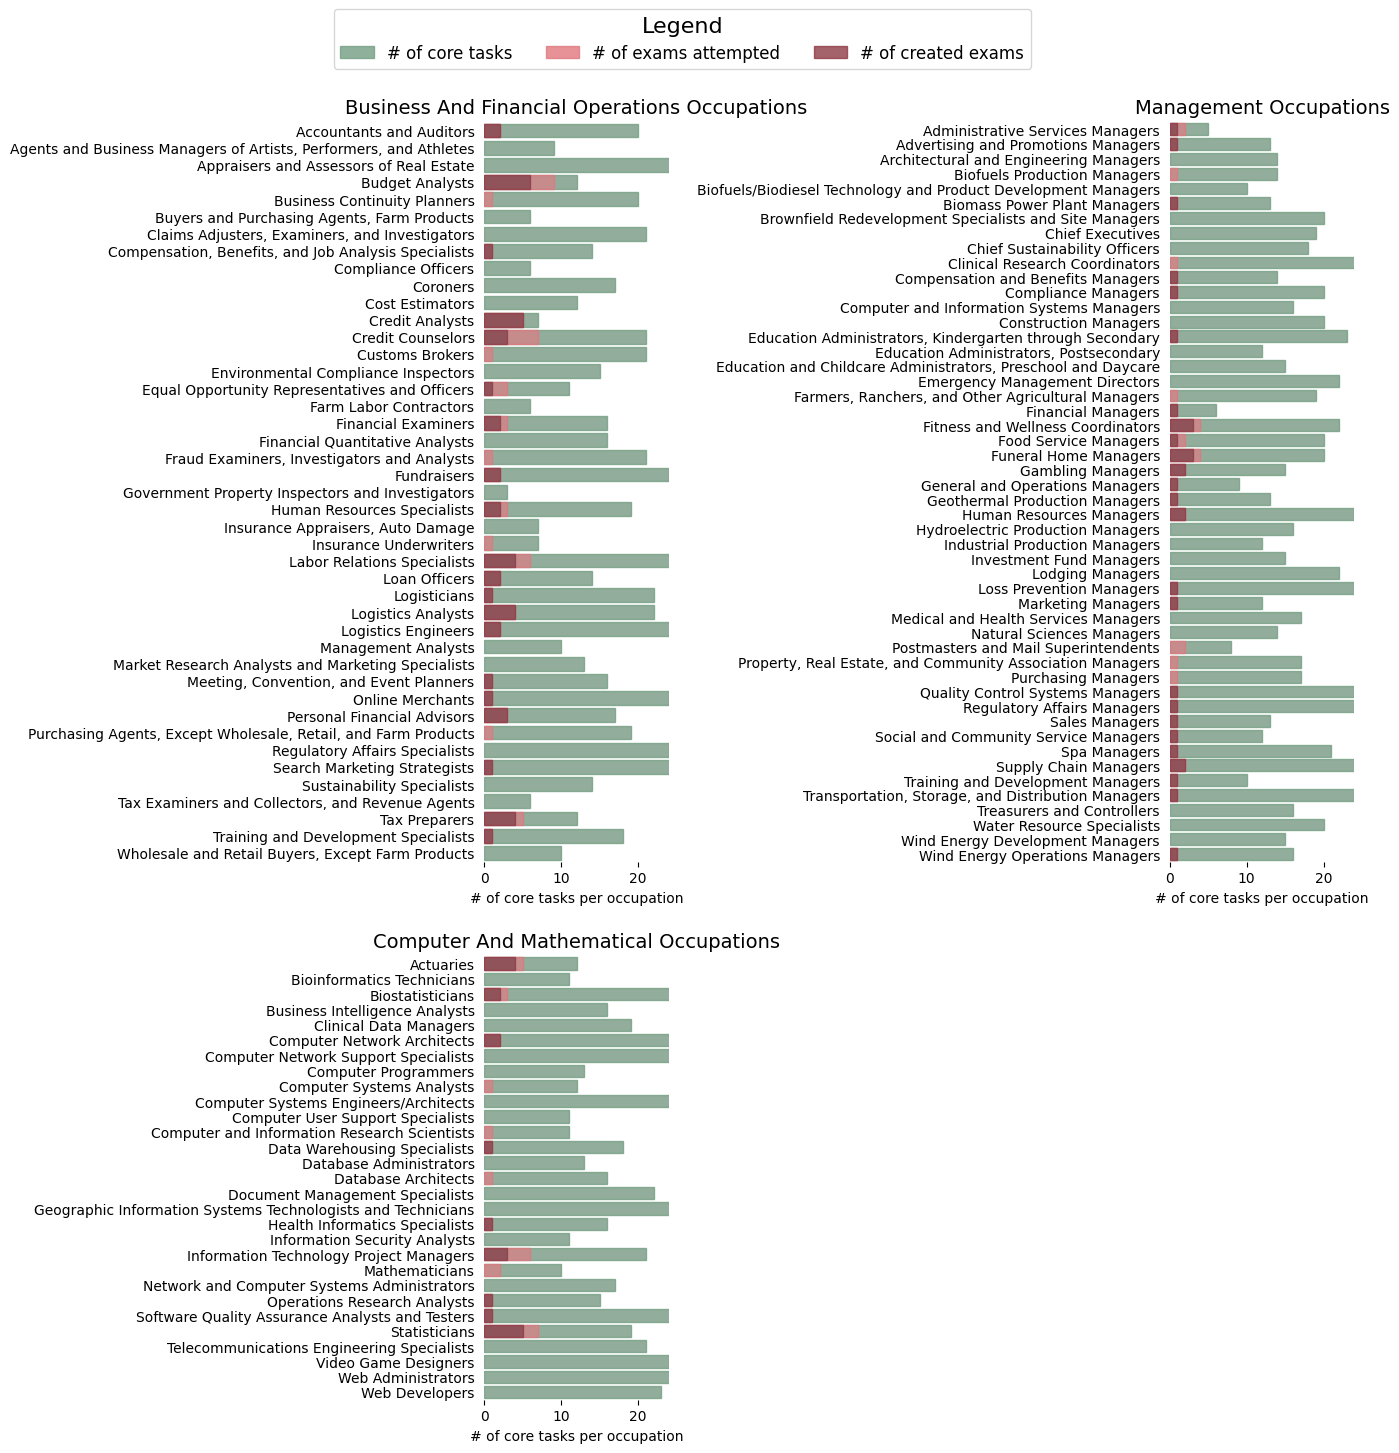

In [210]:

# Create 2x2 grid of subplots
fig, axes = plt.subplots(
    2, 2,
    figsize=(14, 14),
    gridspec_kw={"height_ratios": [5, 3]}  # Top row is 2x the height of the bottom row
)
axes = axes.flatten()
#bar_colors=[#FFBD59, '#38B6FF',#8E3B46]
bar_colors = [
    ("#739E82", "\# of tasks", '# of core tasks'),
    ("#E0777D", "\# of attempts", "# of exams attempted"),
    ("#8E3B46", "\# of successes","# of created exams")
]

# Plot for each occupation group
for idx, group in enumerate(occupations_file_names):
    ax = axes[idx]
    df_occ = counts[counts['occupation_group'] == group]

    for color, name,label in bar_colors:
        sns.barplot(
            x=name,  # gets 'tasks', 'exams', 'successes'
            y="occupation",
            data=df_occ,
            label=label,
            color=color,
            alpha=.8,
            edgecolor=color,
            ax=ax,
            legend=False
        )

    ax.set(xlim=(0, 24), ylabel="", xlabel="# of core tasks per occupation")
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_title(group.replace("_", " ").title(), fontsize=14)

    # Clean up ticks
    ax.tick_params(left=False)
    ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])

# Fourth plot (bottom right) is used for legend only
legend_ax = axes[3]
legend_ax.axis('off')  # Hide the axis

# Create dummy bars for the legend
handles = [
    plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.8)
    for color, name, label in bar_colors
]
labels = [label for _,_, label in bar_colors]
#legend_ax.legend(handles, labels, loc='upper left', fontsize=14, title="Legend")
fig.legend(handles, labels, loc='upper center', fontsize=12, title="Legend", bbox_to_anchor=(0.5, 1.05), ncol=3,title_fontsize=16)

# Adjust layout
plt.tight_layout(pad=2.0)  # Increase padding between subplots
plt.savefig('../../results/figures/tasks_exams_successes_horizontal.pdf', dpi=300, bbox_inches='tight')


/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_99058/3873035950.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])
/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_99058/3873035950.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])
/var/folders/m2/yy15wc4d3zqdtsvvvggmkn780000gp/T/ipykernel_99058/3873035950.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])


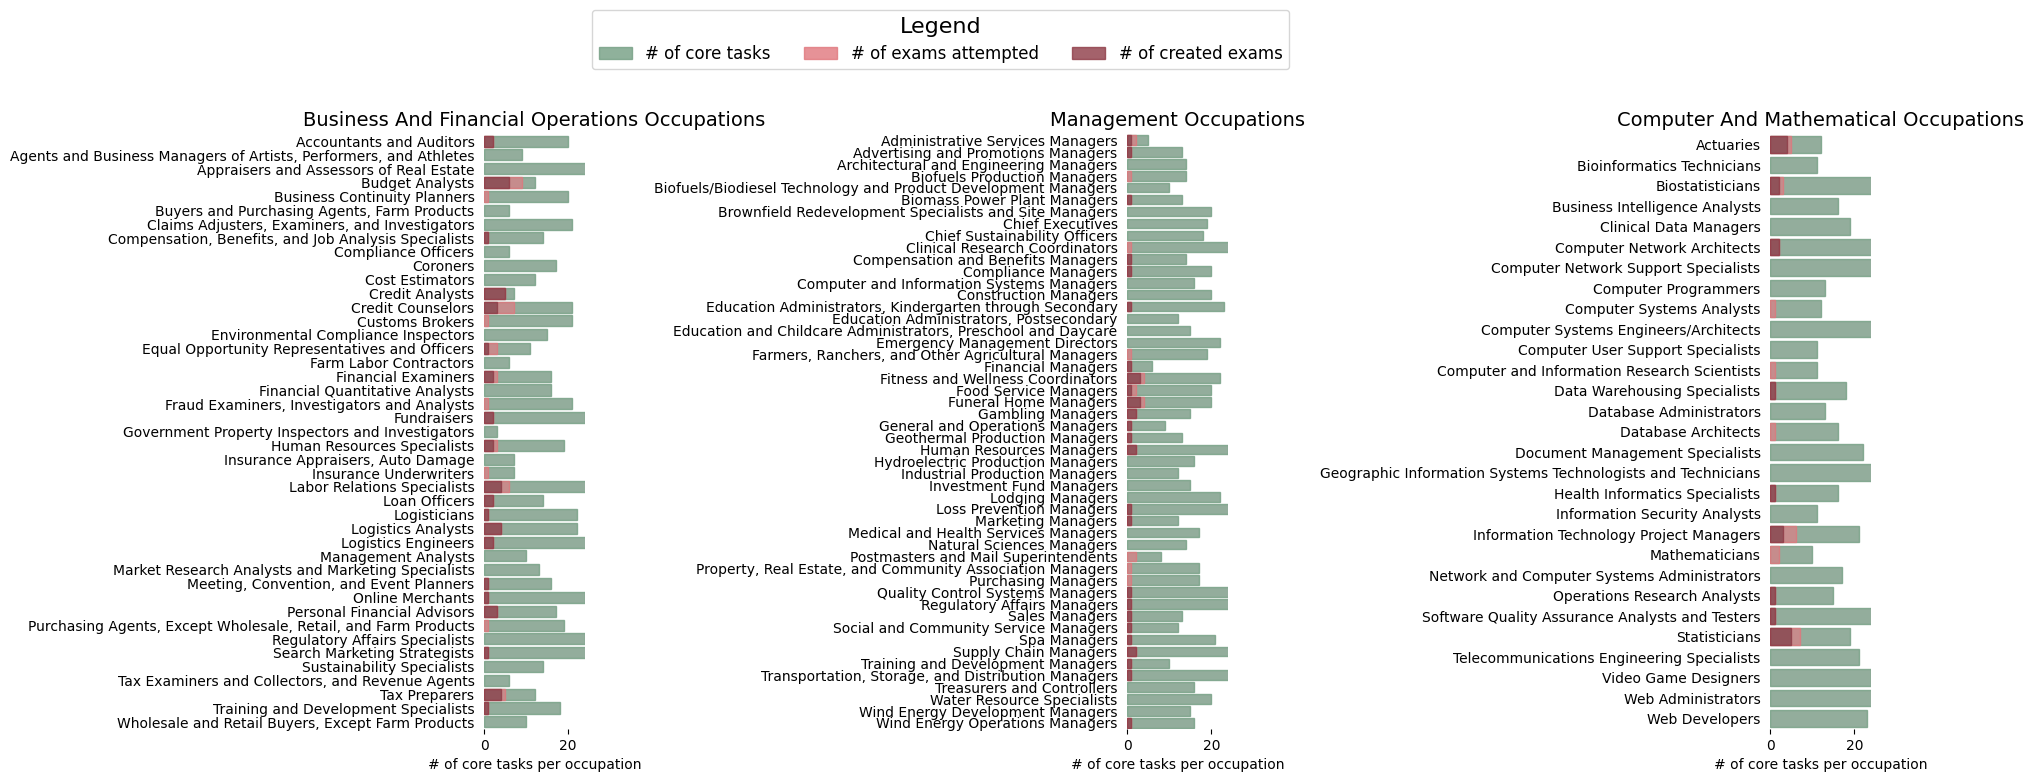

In [219]:

# Create 2x2 grid of subplots
fig, axes = plt.subplots(
    1, 3,
    figsize=(20, 8),
    #gridspec_kw={"height_ratios": [5, 3]}  # Top row is 2x the height of the bottom row
)
axes = axes.flatten()
#bar_colors=[#FFBD59, '#38B6FF',#8E3B46]
bar_colors = [
    ("#739E82", "\# of tasks", '# of core tasks'),
    ("#E0777D", "\# of attempts", "# of exams attempted"),
    ("#8E3B46", "\# of successes","# of created exams")
]

# Plot for each occupation group
for idx, group in enumerate(occupations_file_names):
    ax = axes[idx]
    df_occ = counts[counts['occupation_group'] == group]

    for color, name,label in bar_colors:
        sns.barplot(
            x=name,  # gets 'tasks', 'exams', 'successes'
            y="occupation",
            data=df_occ,
            label=label,
            color=color,
            alpha=.8,
            edgecolor=color,
            ax=ax,
            legend=False
        )

    ax.set(xlim=(0, 24), ylabel="", xlabel="# of core tasks per occupation")
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_title(group.replace("_", " ").title(), fontsize=14)

    # Clean up ticks
    ax.tick_params(left=False)
    ax.set_yticklabels([label.get_text() for label in ax.get_yticklabels()])

# Fourth plot (bottom right) is used for legend only
#legend_ax = axes[3]
#legend_ax.axis('off')  # Hide the axis

# Create dummy bars for the legend
handles = [
    plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.8)
    for color, name, label in bar_colors
]
labels = [label for _,_, label in bar_colors]
#legend_ax.legend(handles, labels, loc='upper left', fontsize=14, title="Legend")
fig.legend(handles, labels, loc='upper center', fontsize=12, title="Legend", bbox_to_anchor=(0.5, 1.05), ncol=3,title_fontsize=16)

# Adjust layout
plt.tight_layout(pad=5.0)  # Increase padding between subplots
plt.savefig('../../results/figures/tasks_exams_successes_horizontal.pdf', dpi=300, bbox_inches='tight')


# Failure Modes

In [104]:
# investigate failure modes
print(np.sum(exam_list['key_grade']<99))
print(np.sum(exam_list['key_grade']>100))
print(np.sum(exam_list['check_no_internet']==False))
print(np.sum(exam_list['failed_candidate_materials']>0))
print(np.sum(exam_list['check_overall_makes_sense']==False))
print(np.sum(exam_list['check_real_materials']==False))

25
10
0
10
1
0


In [105]:
invalid_exams = exam_list[exam_list['exam']=='Exam not valid'].groupby('occupation_group')['task_id'].nunique().rename('\# of invalid exams')
key_grade_low = exam_list[exam_list['key_grade']<99].groupby('occupation_group')['task_id'].nunique().rename('\% of answer keys with score \< 99')
key_grade_high = exam_list[exam_list['key_grade']>100].groupby('occupation_group')['task_id'].nunique().rename('\% of answer keys with score \> 100')
check_no_internet = exam_list[exam_list['check_no_internet']==False].groupby('occupation_group')['task_id'].nunique().rename('\% of exams relying on fabricated websites')
failed_candidate_materials = exam_list[exam_list['failed_candidate_materials']>2].groupby('occupation_group')['task_id'].nunique().rename('\% of exam without separate candidate materials')        
check_overall_makes_sense = exam_list[exam_list['check_overall_makes_sense']==False].groupby('occupation_group')['task_id'].nunique().rename('\% of exams not making sense overall')
check_real_materials = exam_list[exam_list['check_real_materials']==False].groupby('occupation_group')['task_id'].nunique().rename('\% of exams relying on non-existing image materials')


In [106]:
failure_modes = pd.concat([ invalid_exams,key_grade_low, key_grade_high, check_no_internet, failed_candidate_materials, check_overall_makes_sense, check_real_materials], axis=1).fillna(0)
failure_modes =  failure_modes.div(failure_modes['\# of invalid exams'], axis=0).drop('\# of invalid exams', axis=1)
failure_modes = np.round(failure_modes*100,2)
failure_modes.index = [group.title().replace('_',' ') for group in occupations_file_names]
failure_modes

,\% of answer keys with score \< 99,\% of answer keys with score \> 100,\% of exams relying on fabricated websites,\% of exam without separate candidate materials,\% of exams not making sense overall,\% of exams relying on non-existing image materials
Business And Financial Operations Occupations,42.11,21.05,0.0,15.79,0.00,0.0
Computer And Mathematical Occupations,83.33,8.33,0.0,33.33,0.00,0.0
Management Occupations,54.55,45.45,0.0,9.09,9.09,0.0


In [107]:
latex_code = failure_modes.to_latex(
    escape=False,   # Allows LaTeX special characters like '&' to appear correctly
    multicolumn=True,  # Adds multi-column support in the output for the column names
    header=True,    # Include the header row (column labels)
    index=True,
    float_format="%.2f"      # Include the index (row labels)
)
with open("../../results/tables/failure_modes.tex", "w") as f:
    f.write(latex_code)

# Qualitative inspection of failed exams

In [108]:
# check whether there exist an invalid exam where all answers are invalid
# this should not be the case!!! -> ideally zero rows should be returned
exam_list[(exam_list[['answer_valid_chatgpt4o','answer_valid_chatgpt35','answer_valid_deepseek','answer_valid_claude_sonnet','answer_valid_claude_haiku','answer_valid_gemini_flash_15','answer_valid_gemini_flash']].sum(axis=1)==0) * (exam_list['exam']!='Exam not valid')]

,occupation,task_id,task_description,exam_author_model,tools,materials,exam,system_prompt,overview,instructions,...,score_chatgpt4o,score_deepseek,score_gemini_flash_15,score_chatgpt35,score_empty_submission,occupation_group,test_answers_claude_sonnet_35,answer_valid_claude_sonnet_35,errors_claude_sonnet_35,score_claude_sonnet_35


In [109]:
invalid_exams = exam_list[exam_list['exam']=='Exam not valid'][['task_id','task_description']]
latex_code = invalid_exams.to_latex(
    escape=False,   # Allows LaTeX special characters like '&' to appear correctly
    multicolumn=True,  # Adds multi-column support in the output for the column names
    header=True,    # Include the header row (column labels)
    index=True,
    float_format="%.2f"      # Include the index (row labels)
)
with open("../../results/tables/invalid_exams_list.tex", "w") as f:
    f.write(latex_code)

# ARCHIVE

In [110]:
df_no_special = df.drop(['materials.Other.classification','materials.Other.name','tools.Other.classification','tools.Other.name'],axis=1)
df_no_special.columns[df_no_special.isna().any()].tolist()

['tools.Coding',
 'tools.Spreadsheets',
 'tools.Text editor',
 'tools.PDF viewer',
 'tools.Presentation software',
 'tools.Online search engine',
 'tools.Image Generator',
 'materials.Text',
 'materials.Data',
 'materials.Images',
 'materials.Audio files',
 'materials.Video files',
 'materials.Virtual labs or sandbox environments',
 'required_tools',
 'required_tools_standard',
 'required_materials',
 'required_materials_standard']

In [111]:
df[~df['materials.Audio files'].isin(['Required','Not Required'])]['materials.Audio files'].unique()

array([nan], dtype=object)

In [112]:
df_sum = pd.DataFrame()
dfs = []
models = []
failures =pd.DataFrame()
# Walk through all subdirectories and files in the root directory
for root, dirs, files in os.walk(root_dir):
    for file in files:
        # Only process CSV files
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            print(file_path)
            model = os.path.basename(os.path.dirname(file_path))
            models.append(model)
            # Read the CSV file and append it to the list of DataFrames
            df = pd.read_csv(file_path)
            material_columns = ['materials.Text', 'materials.Data',
            'materials.Images', 'materials.Audio files', 'materials.Video files',
            'materials.Virtual labs or sandbox environments']
            tool_columns =  ['tools.Coding', 'tools.Spreadsheets',\
            'tools.Text editor', 'tools.PDF viewer', 'tools.Presentation software',\
            'tools.Online search engine', 'tools.Image Generator']
            relevant_columns = material_columns + tool_columns
            print("Number of NA observations in relevant columns: ", df[relevant_columns].apply(lambda col: ((col != 'Required') & (col != 'Not Required')).sum().max()))
            failures = pd.concat([failures,pd.Series(df[relevant_columns].apply(lambda col: ((col != 'Required') & (col != 'Not Required')).sum()), name=model)], axis=1)
            print('unique values relevant columns ', pd.unique(df[relevant_columns].values.ravel()))
            df_binary = (df[relevant_columns] =='Required').astype(int)
            print(df_binary.shape)

            if df_sum.shape[0]==0:
                df_sum=df_binary
            else:
                df_sum = df_sum.add(df_binary, fill_value=0)
      
            dfs.append(df_sum)
df_combined = pd.concat(dfs, axis=1,  keys=models)
df_all = pd.concat([df[['task_id','occupation']], df_sum], axis=1)


/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/material_lists/claude-3-7-sonnet-20250219/task_list_computer_and_mathematical_occupations_CORE.csv
Number of NA observations in relevant columns:  materials.Text                                    6
materials.Data                                    6
materials.Images                                  6
materials.Audio files                             6
materials.Video files                             6
materials.Virtual labs or sandbox environments    6
tools.Coding                                      6
tools.Spreadsheets                                6
tools.Text editor                                 6
tools.PDF viewer                                  6
tools.Presentation software                       6
tools.Online search engine                        6
tools.Image Generator                             6
dtype: int64
unique values relevant columns  ['Required' 'Not Required' nan]
(547, 13)
/Users/htr365/Do

In [113]:
failures.index = failures.index.str.replace('materials.', '', regex=True).str.replace('tools.', '', regex=True)
failures

,claude-3-7-sonnet-20250219,claude-3-7-sonnet-20250219,claude-3-7-sonnet-20250219,claude-3-7-sonnet-20250219,claude-3-7-sonnet-20250219
Text,6,1,56,22,0
Data,6,1,56,22,0
Images,6,1,56,22,0
Audio files,6,1,56,22,0
Video files,6,1,56,22,0
Virtual labs or sandbox environments,6,1,56,22,0
Coding,6,1,56,22,0
Spreadsheets,6,1,56,22,0
Text editor,6,1,56,22,0
PDF viewer,6,1,56,22,0


In [114]:
    # path_to_data = '../../data/exam_approach/test_results/'
    # for root, dirs, files in os.walk(path_to_data):
    #     for file in files:
    #         if file.endswith('.csv'):
    #             file_path = os.path.join(root, file)
    #             model = os.path.basename(os.path.dirname(file_path))  # Get only the last directory
    #             print('Looking at the exam created by ', model)
    #             df = pd.read_csv(file_path)
    #             print()
    #             print('Overall ', df.shape[0], ' tasks in the data')

    #             print('num na gemini ', df['test_answers_gemini'].isna().sum())
    #             print('num na claude ', df['test_answers_claude'].isna().sum())
    #             print('num na gpt4 ', df['test_answers_chatgpt4o'].isna().sum())
    #             print('num na gpt35 ', df['test_answers_chatgpt35'].isna().sum())
    #             print('num na deepseek ', df['test_answers_deepseek'].isna().sum())
           


In [115]:
for root, dirs, files in os.walk(root_dir):
    for file in files:
        # Only process CSV files
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            print(file_path)

            # Read the CSV file and append it to the list of DataFrames
            df = pd.read_csv(file_path)
            print(df.shape)
            print(df.dropna().shape)

/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/material_lists/claude-3-7-sonnet-20250219/task_list_computer_and_mathematical_occupations_CORE.csv
(547, 30)
(439, 30)
/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/material_lists/claude-3-7-sonnet-20250219/task_list_business_and_financial_operations_occupations_CORE_automatable.csv
(435, 30)
(297, 30)
/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/material_lists/claude-3-7-sonnet-20250219/task_list_management_occupations_CORE.csv
(843, 30)
(632, 30)
/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/material_lists/claude-3-7-sonnet-20250219/task_list_business_and_financial_operations_occupations_CORE.csv
(675, 31)
(494, 31)
/Users/htr365/Documents/PhD/21_automatisation/gpt_eval/data/exam_approach/material_lists/claude-3-7-sonnet-20250219/task_list_legal_occupations_CORE.csv
(85, 30)
(82, 30)


In [116]:
multiindex_tuples = [('Tools', col.replace("tools.", "").strip()) if 'tool' in col else ('Materials', col.replace("materials.", "").strip()) for col in relevant_columns]


In [117]:
overview_per_occupation = pd.concat([df['occupation'],df_binary],axis=1).groupby('occupation').sum()
overview_per_occupation.columns = pd.MultiIndex.from_tuples(multiindex_tuples, names=['Materials','Tools'])
counts_per_occupation = df.groupby('occupation').size()
overview_per_occupation['Core tasks per occupation'] = counts_per_occupation

overview_per_occupation = overview_per_occupation[['Core tasks per occupation','Materials','Tools']]

In [118]:
overview_per_occupation.columns.names = [None, None]
overview_per_occupation.index.rename('Occupation', inplace=True)
overview_per_occupation

Core tasks per occupation  \
                                                                               
Occupation                                                                     
Administrative Law Judges, Adjudicators, and He...                        12   
Arbitrators, Mediators, and Conciliators                                  11   
Judges, Magistrate Judges, and Magistrates                                15   
Judicial Law Clerks                                                       10   
Lawyers                                                                   18   
Paralegals and Legal Assistants                                            8   
Title Examiners, Abstractors, and Searchers                               11   

                                                   Materials              \
                                                        Text Data Images   
Occupation                                                                 
Administrative Law Judges, Adjudicators, and He...        12   11      5   
Arbitrators, Mediators, and Conciliators                  11    9      2   
Judges, Magistrate Judges, and Magistrates                15   11      5   
Judicial Law Clerks                                       10    6      0   
Lawyers                                                   18   18      8   
Paralegals and Legal Assistants                            8    8      1   
Title Examiners, Abstractors, and Searchers               11   11     11   

                                                                            \
                                                   Audio files Video files   
Occupation                                                                   
Administrative Law Judges, Adjudicators, and He...           3           4   
Arbitrators, Mediators, and Conciliators                     2           6   
Judges, Magistrate Judges, and Magistrates                   2           8   
Judicial Law Clerks                                          1           1   
Lawyers                                                      4           5   
Paralegals and Legal Assistants                              1           2   
Title Examiners, Abstractors, and Searchers                  0           0   

                                                                                         \
                                                   Virtual labs or sandbox environments   
Occupation                                                                                
Administrative Law Judges, Adjudicators, and He...                                    4   
Arbitrators, Mediators, and Conciliators                                              0   
Judges, Magistrate Judges, and Magistrates                                            5   
Judicial Law Clerks                                                                   1   
Lawyers                                                                               4   
Paralegals and Legal Assistants                                                       3   
Title Examiners, Abstractors, and Searchers                                           6   

                                                    Tools               \
                                                   Coding Spreadsheets   
Occupation                                                               
Administrative Law Judges, Adjudicators, and He...      0            0   
Arbitrators, Mediators, and Conciliators                0            0   
Judges, Magistrate Judges, and Magistrates              0            2   
Judicial Law Clerks                                     0            0   
Lawyers                                                 0            1   
Paralegals and Legal Assistants                         0            2   
Title Examiners, Abstractors, and Searchers             0            2   

                                                        

In [119]:

# # Convert the DataFrame to LaTeX format
# latex_code = overview_per_occupation.to_latex(
#     escape=False,   # Allows LaTeX special characters like '&' to appear correctly
#     multicolumn=True,  # Adds multi-column support in the output for the column names
#     header=True,    # Include the header row (column labels)
#     index=True      # Include the index (row labels)
# )
# with open("../../results/tables/material_tools_count_claude.tex", "w") as f:
#     f.write(latex_code)

# print("LaTeX code saved to 'output_table.tex'")

In [120]:
df_combined.columns.get_level_values(1).unique()

Index(['materials.Text', 'materials.Data', 'materials.Images',
       'materials.Audio files', 'materials.Video files',
       'materials.Virtual labs or sandbox environments', 'tools.Coding',
       'tools.Spreadsheets', 'tools.Text editor', 'tools.PDF viewer',
       'tools.Presentation software', 'tools.Online search engine',
       'tools.Image Generator'],
      dtype='object')

In [121]:
# Get unique higher-level groups
group_names = df_combined.columns.get_level_values(0).unique()

# Dictionary to store pairwise correlation matrices
corr_matrices = []
relevant_columns = [s.replace(" or sandbox environments","") for s in relevant_columns]# Compute pairwise correlations and stack them horizontally
multiindex_tuples = [('Tools', col.replace("tools.", "").strip()) if 'tool' in col else ('Materials', col.replace("materials.", "").strip()) for col in relevant_columns]
for grp1, grp2 in itertools.combinations(group_names, 2):
    df_grp1 = df_combined[grp1]
    df_grp2 = df_combined[grp2]
    
    # Compute correlation between features of the two groups
    corr_matrix = df_grp1.corrwith(df_grp2, axis=0).to_frame()
    corr_matrix.columns = [f"{grp1} vs {grp2}"]  # Rename column
    corr_matrices.append(corr_matrix)

# Combine all pairwise correlation matrices horizontally
corr_combined = pd.concat(corr_matrices, axis=1)
#corr_combined.index.name = None
corr_combined.set_index(pd.MultiIndex.from_tuples(multiindex_tuples),inplace=True)
corr_combined = corr_combined.swaplevel(0, 1).dropna(how='all')
# Plot single heatmap
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
#plt.figure(figsize=(12, 6))
sns.heatmap(corr_combined, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

#Below 3 lines remove default labels
labels = ['' for item in ax.get_yticklabels()]

ax.set_yticklabels(labels)
ax.set_ylabel('')

label_group_bar_table(ax, corr_combined)
fig.subplots_adjust(bottom=.1*corr_combined.index.nlevels)

plt.title("Pairwise Correlation between requirements assessments")
plt.show()



ValueError: No objects to concatenate

In [ ]:

# Combine all pairwise correlation matrices horizontally
corr_combined = pd.concat(corr_matrices, axis=1)
#corr_combined.index.name = None
corr_combined.set_index(pd.MultiIndex.from_tuples(multiindex_tuples),inplace=True)

corr_combined

deepseek-chat vs gpt-4o  \
Materials Text                                                      NaN   
          Data                                                 1.000000   
          Images                                               0.927831   
          Audio files                                          1.000000   
          Video files                                          1.000000   
          Virtual labs or sandbox environments                 0.945537   
Tools     Coding                                                    NaN   
          Spreadsheets                                         1.000000   
          Text editor                                          0.935495   
          PDF viewer                                           1.000000   
          Presentation software                                0.812296   
          Web Browser                                               NaN   
          Image Generator                                           NaN   

                                                deepseek-chat vs claude-3-7-sonnet-20250219  \
Materials Text                                                                          NaN   
          Data                                                                     1.000000   
          Images                                                                   0.870388   
          Audio files                                                              0.866507   
          Video files                                                              0.866507   
          Virtual labs or sandbox environments                                     0.686403   
Tools     Coding                                                                        NaN   
          Spreadsheets                                                             0.834404   
          Text editor                                                              0.936484   
          PDF viewer                                                               1.000000   
          Presentation software                                                    0.866507   
          Web Browser                                                                   NaN   
          Image Generator                                                               NaN   

                                                deepseek-chat vs gpt-3.5-turbo-0125  \
Materials Text                                                                  NaN   
          Data                                                             1.000000   
          Images                                                           0.845201   
          Audio files                                                      0.919176   
          Video files                                                      0.919176   
          Virtual labs or sandbox environments                             0.736473   
Tools     Coding                                                                NaN   
          Spreadsheets                                                     0.898027   
          Text editor                                                      0.913480   
          PDF viewer                                                       1.000000   
          Presentation software                                            0.797080   
          Web Browser                                                           NaN   
          Image Generator                                                       NaN   

                                                deepseek-chat vs gemini-2.0-flash  \
Materials Text                                                                NaN   
          Data                                                           0.942936   
          Images                                                         0.854167   
          Audio files                                                    0.821054   
          Video files 

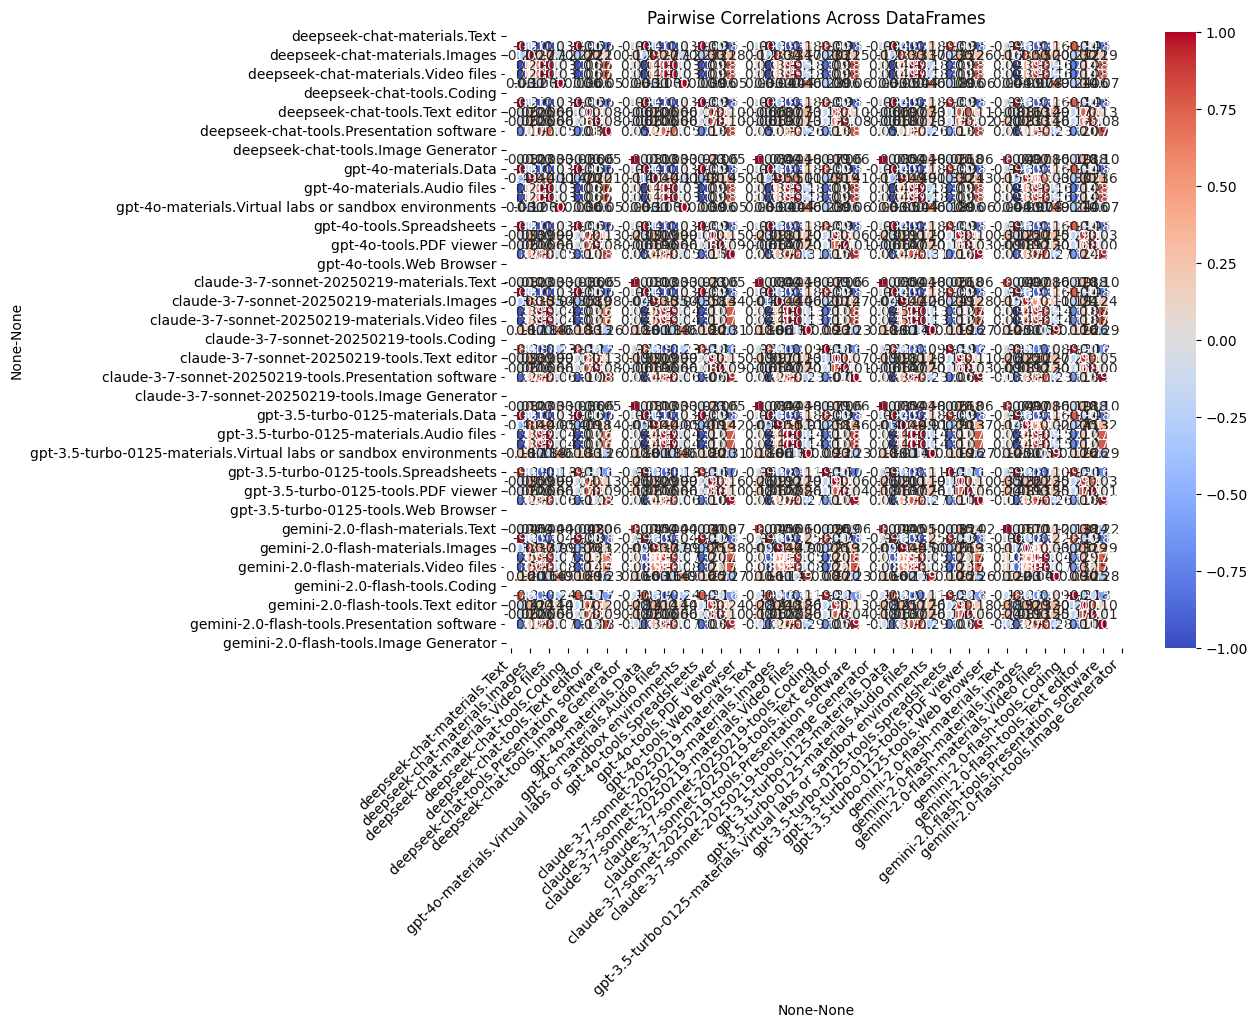

In [ ]:
# Plot heatmap
corr_results = df_combined.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_results, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Enhance visualization
plt.title("Pairwise Correlations Across DataFrames")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.show()

In [ ]:
corr_results

deepseek-chat                 \
                                             materials.Text materials.Data   
deepseek-chat    materials.Text                         NaN            NaN   
                 materials.Data                         NaN       1.000000   
                 materials.Images                       NaN      -0.266398   
                 materials.Audio files                  NaN      -1.000000   
                 materials.Video files                  NaN      -1.000000   
...                                                     ...            ...   
gemini-2.0-flash tools.Text editor                      NaN      -0.140894   
                 tools.PDF viewer                       NaN      -0.059868   
                 tools.Presentation software            NaN      -0.803759   
                 tools.Web Browser                      NaN            NaN   
                 tools.Image Generator                  NaN            NaN   

                                                               \
                                             materials.Images   
deepseek-chat    materials.Text                           NaN   
                 materials.Data                     -0.266398   
                 materials.Images                    1.000000   
                 materials.Audio files               0.266398   
                 materials.Video files               0.266398   
...                                                       ...   
gemini-2.0-flash tools.Text editor                   0.317332   
                 tools.PDF viewer                    0.224733   
                 tools.Presentation software         0.192933   
                 tools.Web Browser                        NaN   
                 tools.Image Generator                    NaN   

                                                                    \
                                             materials.Audio files   
deepseek-chat    materials.Text                                NaN   
                 materials.Data                          -1.000000   
                 materials.Images                         0.266398   
                 materials.Audio files                    1.000000   
                 materials.Video files                    1.000000   
...                                                            ...   
gemini-2.0-flash tools.Text editor                        0.140894   
                 tools.PDF viewer                         0.059868   
                 tools.Presentation software              0.803759   
                 tools.Web Browser                             NaN   
                 tools.Image Generator                         NaN   

                                                                    \
                                             materials.Video files   
deepseek-chat    materials.Text                                NaN   
                 materials.Data                          -1.000000   
                 materials.Images                         0.266398   
                 materials.Audio files                    1.000000   
                 materials.Video files                    1.000000   
...                                                            ...   
gemini-2.0-flash tools.Text editor                        0.140894   
                 tools.PDF viewer                         0.059868   
                 tools.Presentation software              0.803759   
                 tools.Web Browser                             NaN   
                 tools.Image Generator                         NaN   

                                                                                             \
                                             materials.Virtual labs or sandbox environments   
deepseek-chat    materials.Text                                                         NaN   
                 materials.Data                                               

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


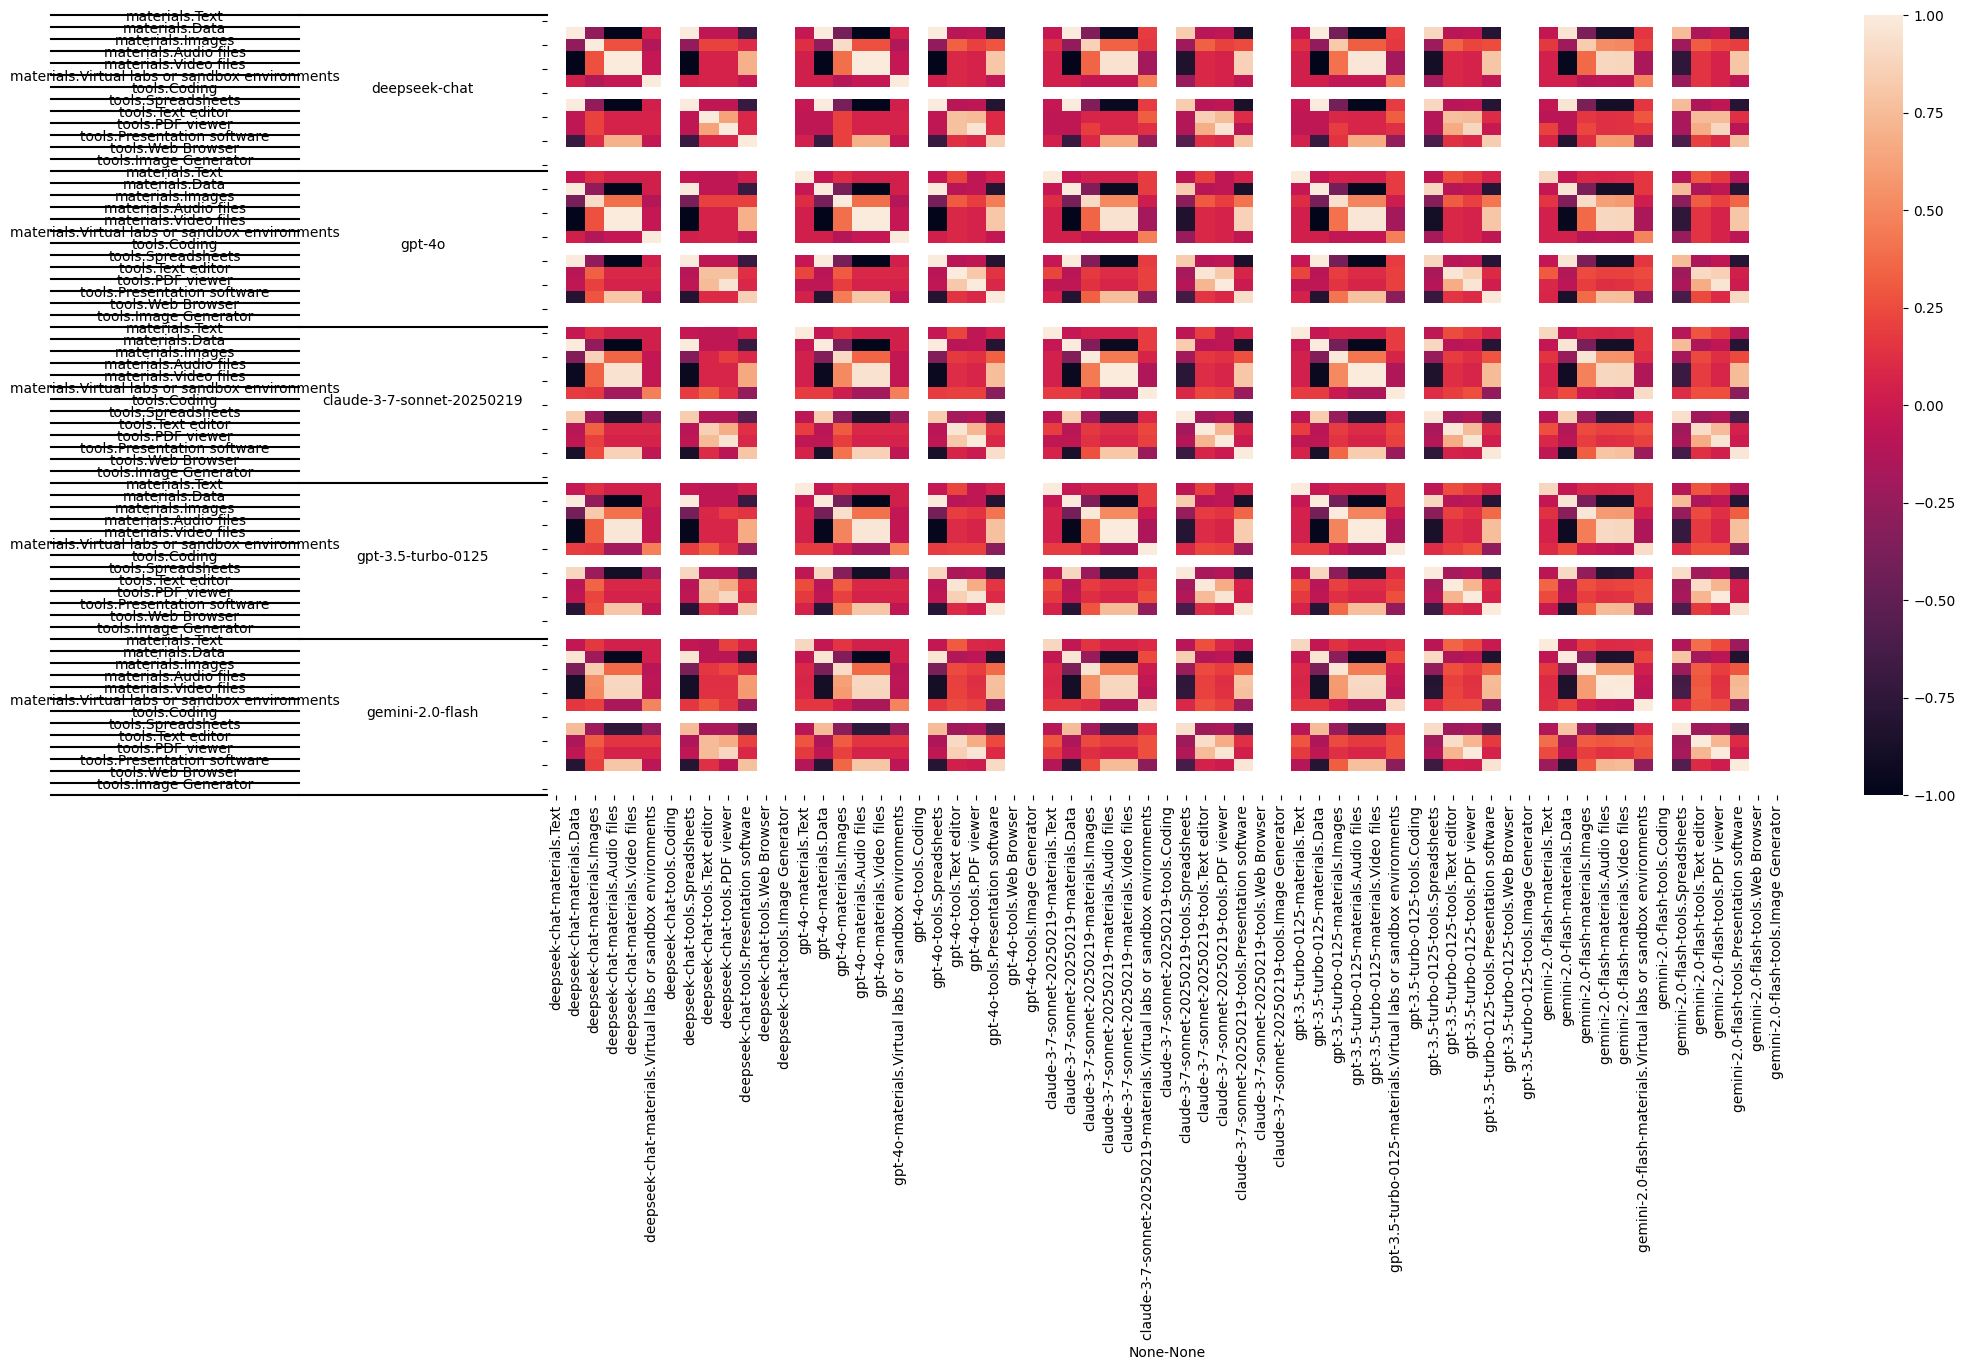

In [ ]:

def test_table():
    months = [datetime.date(2008, i+1, 1).strftime('%B') for i in range(12)]
    seasons = ['Winter',]*3 + ['Spring',]*2 + ['Summer']*3 + ['Pre-Winter',]*4
    tuples = list(zip(months, seasons))
    index = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])
    d = {i: [np.random.randint(0,50) for _ in range(12)] for i in range(1950, 1960)}
    df = pd.DataFrame(d, index=index)
    return df

def add_line(ax, xpos, ypos):
    line = plt.Line2D([ypos, ypos+ .2], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    xpos = -.2
    scale = 1./df.index.size
    for level in range(df.index.nlevels):
        pos = df.index.size
        for label, rpos in label_len(df.index,level):
            add_line(ax, pos*scale, xpos)
            pos -= rpos
            lypos = (pos + .5 * rpos)*scale
            ax.text(xpos+.1, lypos, label, ha='center', transform=ax.transAxes) 
        add_line(ax, pos*scale , xpos)
        xpos -= .2

#df = test_table()

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
sns.heatmap(corr_results)

#Below 3 lines remove default labels
labels = ['' for item in ax.get_yticklabels()]
print(labels)
ax.set_yticklabels(labels)
ax.set_ylabel('')

label_group_bar_table(ax, corr_results)
fig.subplots_adjust(bottom=.1*df.index.nlevels)
plt.show()

In [ ]:

def test_table():
    months = [datetime.date(2008, i+1, 1).strftime('%B') for i in range(12)]
    seasons = ['Winter']*3 + ['Spring']*2 + ['Summer']*3 + ['Pre-Winter']*4
    tuples = list(zip(months, seasons))
    index = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])
    
    # Create 10 years of data for 1950 to 1959
    years = [i for i in range(1950, 1960)]
    d = {year: [np.random.randint(0, 50) for _ in range(12)] for year in years}
    df = pd.DataFrame(d, index=index)
    
    # Create 5-year bins for the columns
    bin_labels = [f'{bin_start}-{bin_start+4}' for bin_start in range(1950, 1960, 5)]
    bins = pd.cut(df.columns, bins=[1950, 1955, 1960], right=False, labels=bin_labels)
    
    # Create decades for the columns (second level)
    decades = [f'{(year // 10) * 10}s' for year in df.columns]
    
    # Create multi-level columns: first level is 5-year bins, second level is decade
    columns = pd.MultiIndex.from_tuples(zip(bins, decades), names=['5_year_bin', 'decade'])
    df.columns = columns

    return df

def add_line(ax, xpos, ypos):
    line = plt.Line2D([ypos, ypos + .2], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index, level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k, g in groupby(labels)]

def label_group_bar_table(ax, df):
    xpos = -.2
    scale = 1. / df.index.size
    for level in range(df.index.nlevels):
        pos = df.index.size
        for label, rpos in label_len(df.index, level):
            add_line(ax, pos * scale, xpos)
            pos -= rpos
            lypos = (pos + .5 * rpos) * scale
            ax.text(xpos + .1, lypos, label, ha='center', transform=ax.transAxes)
        add_line(ax, pos * scale, xpos)
        xpos -= .2

# Create the DataFrame with multi-level column bins and decades
df = test_table()

# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Create heatmap for the DataFrame
sns.heatmap(df, ax=ax, cmap='Blues', cbar_kws={'label': 'Value'})

# Below 3 lines remove default labels
labels = ['' for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_ylabel('')

# Add group labels for the row index (months and seasons)
label_group_bar_table(ax, df)

# Adjust subplots for the labels
fig.subplots_adjust(bottom=.1 * df.index.nlevels)
plt.show()


In [ ]:
corr_results

In [ ]:
relevant_columns

In [ ]:
nice names =["Text instructions", "Longform text", " Data", "Images", "Audio files", "Virtual labs", "Python","Excel","Word","PDF viewer","PowerPoint", "Web browser", "Image generator"]

In [ ]:
def compare_cells_percentage(dfs):
    # Create an empty DataFrame to store the percentages of matching cells
    result = pd.DataFrame(index=dfs[0].index, columns=dfs[0].columns)
    
    # Iterate through each cell
    for col in dfs[0].columns:
        for row in dfs[0].index:
            # Get the values of the current cell in each DataFrame
            values = [df.at[row, col] for df in dfs]
            
            # Calculate the percentage of matching values for this cell
            matching_count = sum([1 for value in values if value == values[0]])  # Compare all values to the first value
            result.at[row, col] = matching_count / len(dfs) * 100  # Percentage of matching values

    return result

df_percentage_comparison = compare_cells_percentage(dfs)


In [ ]:
# get agreement for tools and materials across models
df_percentage_comparison.mean(axis=0)


In [ ]:
df_half = (df_sum>len(models)/2).astype(int)

In [ ]:
df_occ = pd.concat([df['occupation'], df_half],axis=1).groupby('occupation').mean()
df_occ

In [ ]:
# Assuming 'df' is your DataFrame with occupations as the index
plt.figure(figsize=(12, 6))

# Create the heatmap
sns.heatmap(df_occ*100, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)

# Improve readability
plt.title("Material & Tool Usage Heatmap", fontsize=14)
plt.xlabel("Materials & Tools", fontsize=12)
plt.ylabel("Occupation", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Show plot
plt.show()

In [ ]:
    # Identify columns related to tools (starting with 'tool')
    df["required_tools"] = df.apply(get_required, axis=1, args=('tools.', tool_columns))

    # Identify columns related to materials (starting with 'material')


In [ ]:
result = df1.add(df2, fill_value=0).add(df3, fill_value=0).add(df4, fill_value=0)
